<a href="https://colab.research.google.com/github/hkjal1605/Plant-Disease-Prediction/blob/master/Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Panthology Project(Identify the category of foliar diseases in apple trees)
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

### Data:
We are using data from Kaggle's `Plant Pathology 2020 - FGVC7` project.
      
https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview/description

## Get our workspace ready

In [4]:
# import tensorflow and tensorflowhub
import tensorflow as tf
import tensorflow_hub as hub

print("Tensorflow version:", tf.__version__)
print("Tensorflow Hub Version:", hub.__version__)

Tensorflow version: 2.2.0-rc2
Tensorflow Hub Version: 0.7.0


## Get our data ready(Turning data into Tensors)
for machine learning models, we have to convert our images into numerical format. So we will be converting our images into Tensors.

In [5]:
import pandas as pd

train_labels = pd.read_csv('drive/My Drive/Plant Pathology Project/train.csv')
train_labels.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [0]:
# Check the number of labels
train_labels['healthy'].value_counts()

0    1305
1     516
Name: healthy, dtype: int64

In [0]:
train_labels['rust'].value_counts()

0    1199
1     622
Name: rust, dtype: int64

In [0]:
train_labels['multiple_diseases'].value_counts()

0    1730
1      91
Name: multiple_diseases, dtype: int64

In [0]:
train_labels['scab'].value_counts()

0    1229
1     592
Name: scab, dtype: int64

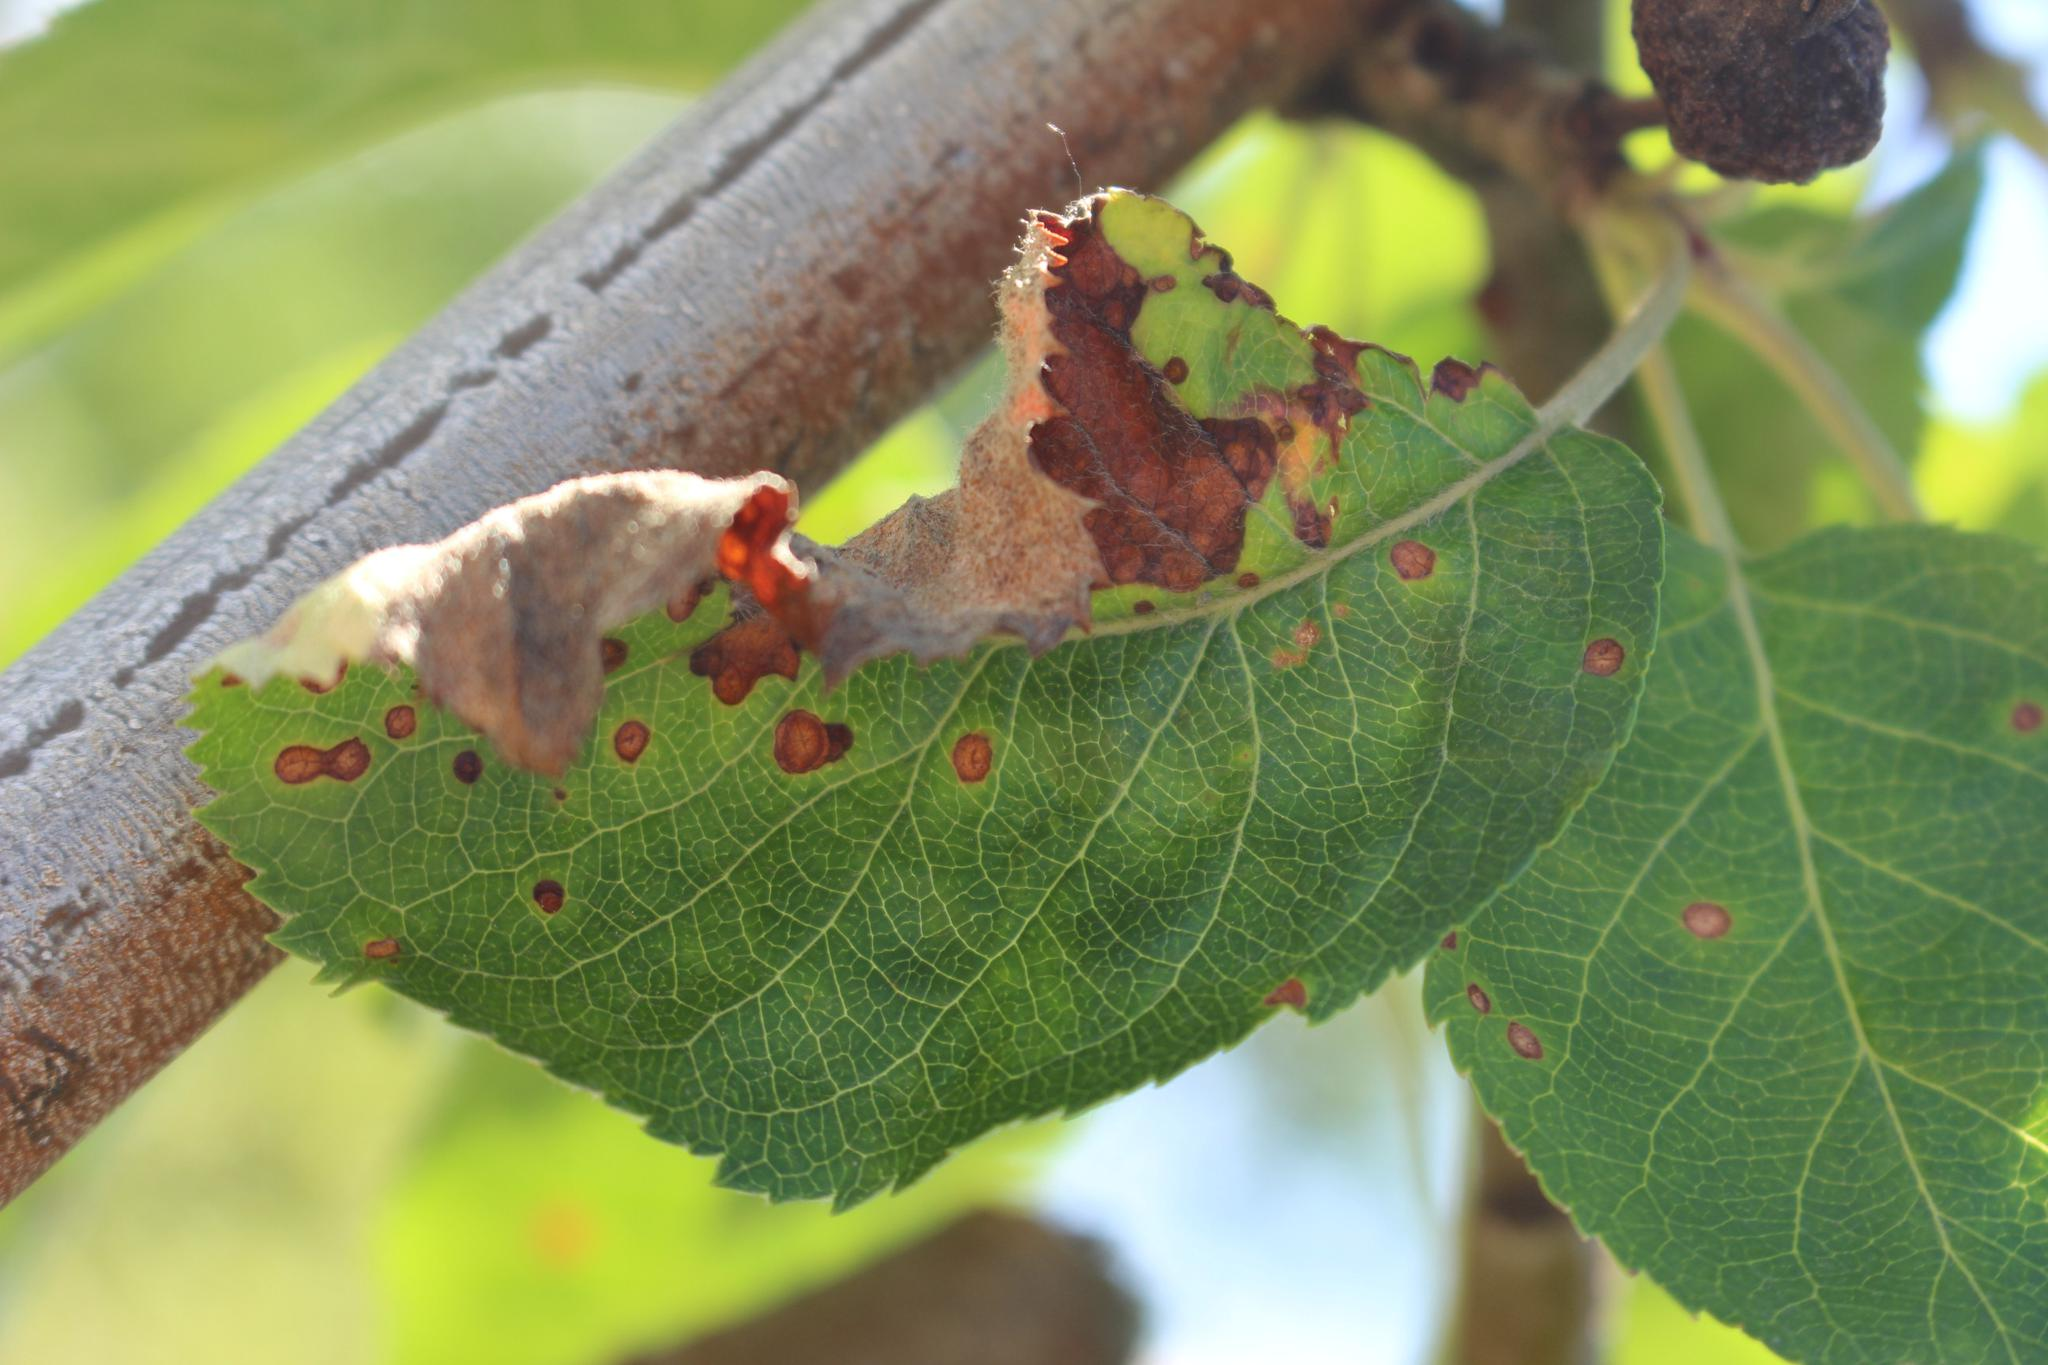

In [0]:
# Let's view an image
from IPython.display import Image
Image('drive/My Drive/Plant Pathology Project/images/Train_1.jpg')

## Getting images and their labels

Get a list of our image filenames

In [0]:
# Create filenames
filenames = ['drive/My Drive/Plant Pathology Project/images/' + fname for fname in train_labels['image_id'] + '.jpg']

filenames[:10]

['drive/My Drive/Plant Pathology Project/images/Train_0.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_1.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_2.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_3.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_4.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_5.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_6.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_7.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_8.jpg',
 'drive/My Drive/Plant Pathology Project/images/Train_9.jpg']

In [0]:
len(filenames)

1821

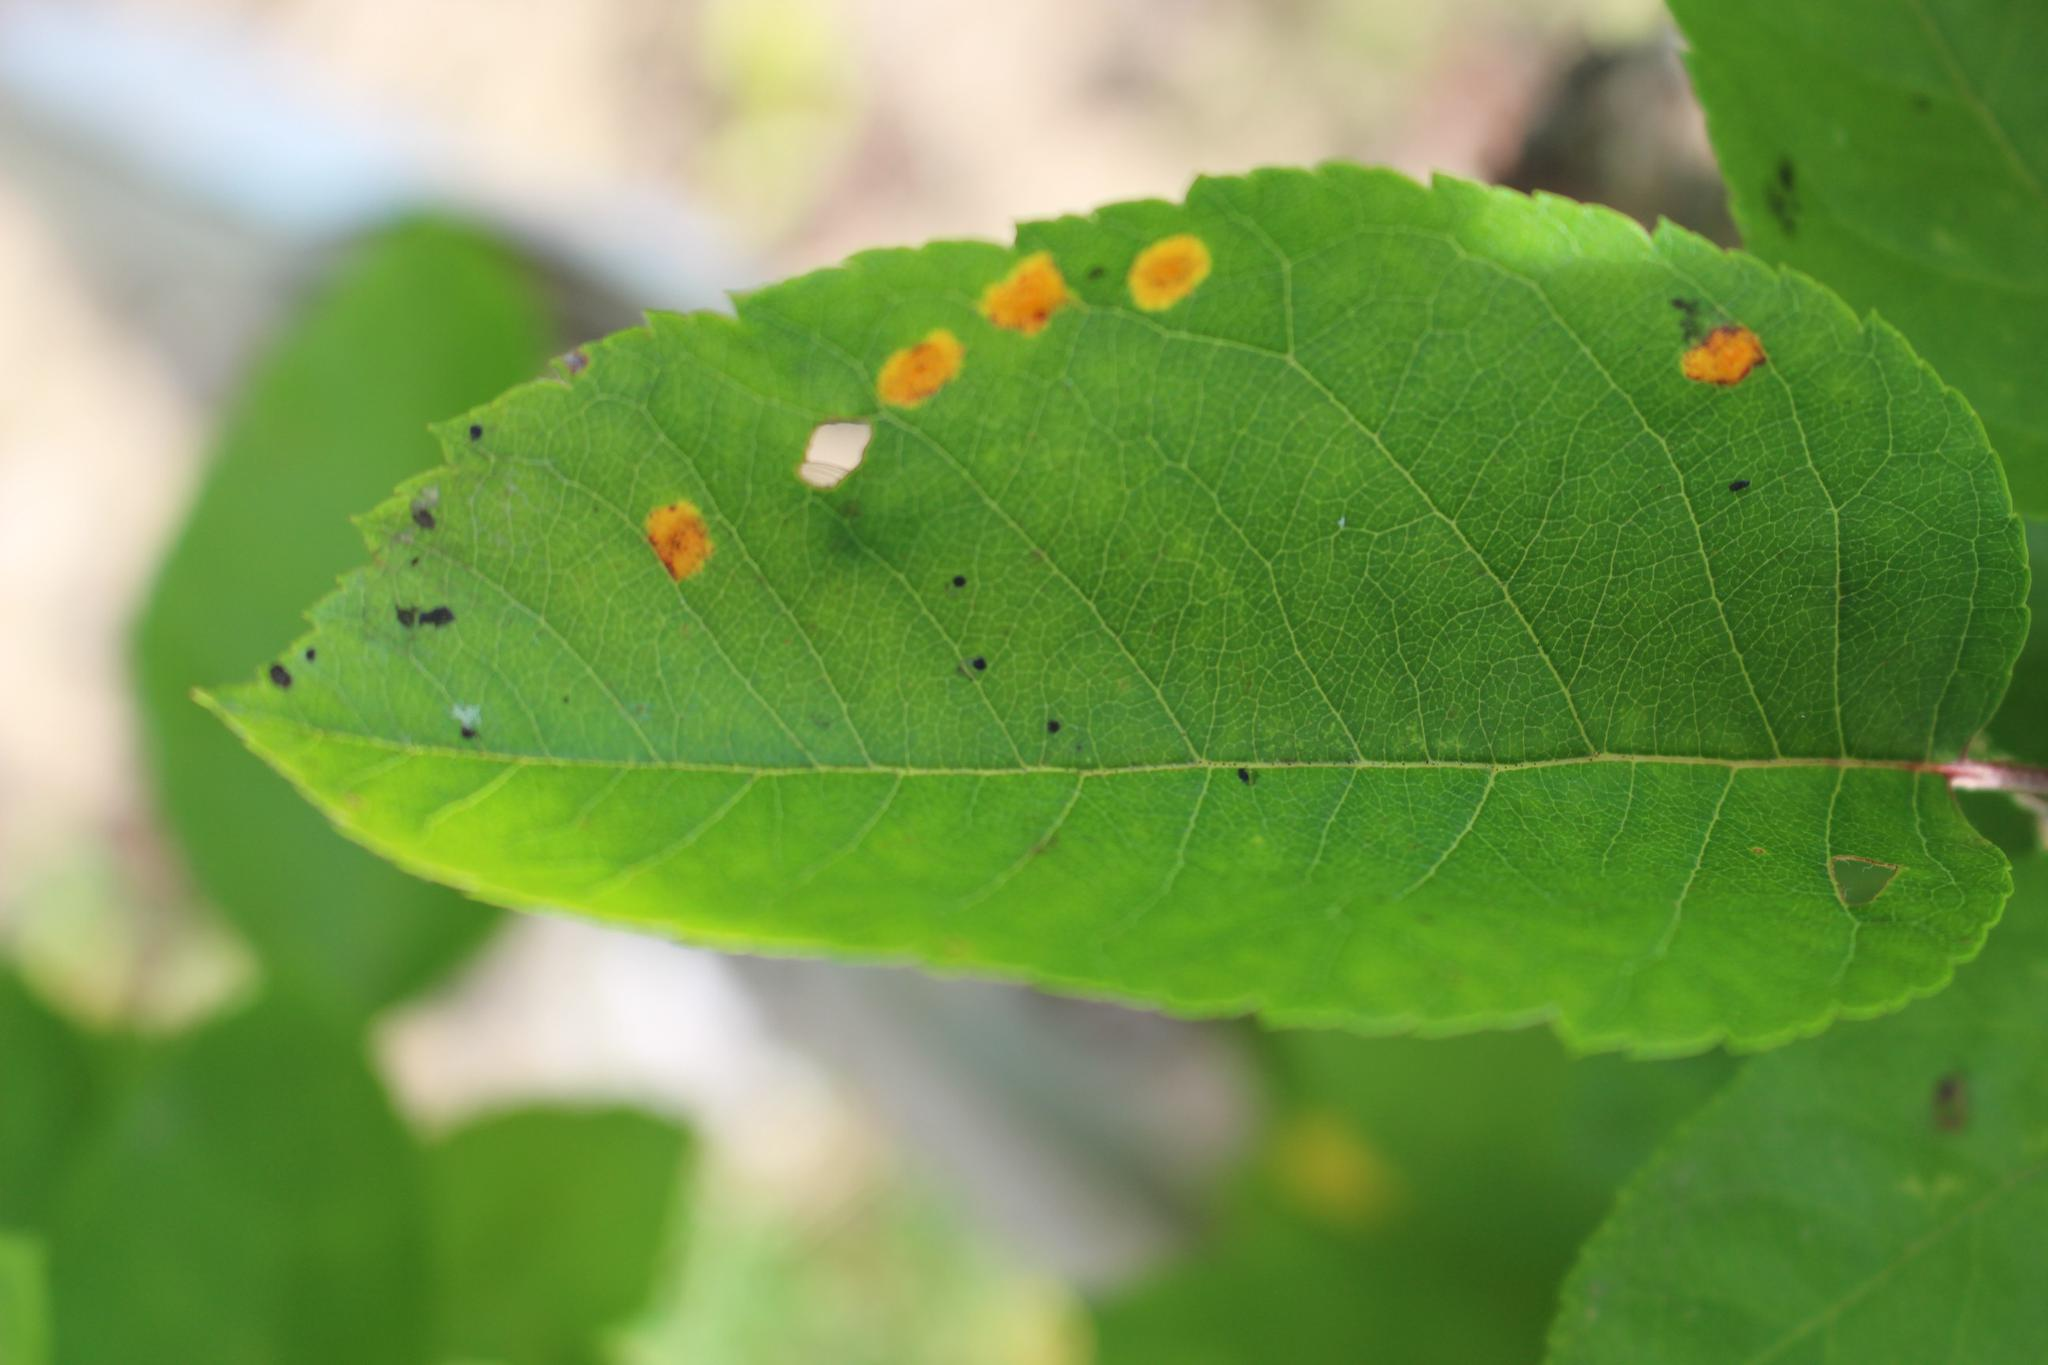

In [0]:
# One more check
Image(filenames[1200])

* Since our labels are already in numerical form, we can proceed to create the model.

## Creating our own validation set

In [0]:
X = filenames
y = train_labels.drop('image_id', axis=1)

In [0]:
# Let's split the data into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_val), len(y_train), len(y_val)

(1456, 365, 1456, 365)

In [0]:
X_train[:5], y_train[:5]

(['drive/My Drive/Plant Pathology Project/images/Train_194.jpg',
  'drive/My Drive/Plant Pathology Project/images/Train_1331.jpg',
  'drive/My Drive/Plant Pathology Project/images/Train_176.jpg',
  'drive/My Drive/Plant Pathology Project/images/Train_1078.jpg',
  'drive/My Drive/Plant Pathology Project/images/Train_1749.jpg'],
       healthy  multiple_diseases  rust  scab
 194         0                  0     1     0
 1331        0                  0     0     1
 176         0                  0     0     1
 1078        0                  0     1     0
 1749        0                  0     1     0)

## Preprocessing images(Turning images into Tensors)

We will create a function to take the filenames of the images and convcert them into tensors.

In [0]:
IMG_SIZE = 224

def process_image(image_path):
  # Read the image
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 channels(RBG)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channels values from 0-225 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desied value
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

Now we will divide our data into batches

In [0]:
# Create a function to return a tuple(image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)

  return image,label

In [0]:
# Define a batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):

  # If the data is test dataset, it will not have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # If the data is validation dataset, we don't need to shufflr it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print('Creating training data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    
    # Shuffle the images
    data = data.shuffle(buffer_size=len(X))

    data = data.map(get_image_label)

    data_batch = data.batch(batch_size)

    return data_batch

In [0]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [0]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.int64, name=None)))

## Visualising data batches

In [0]:
import matplotlib.pyplot as plt

# Create a function to display 25 images 
def show_25_images(images, label):
  for i in range(25):
    # Create subplots(5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)

    # Display the image
    plt.imshow(images[i])
    plt.axis('off')

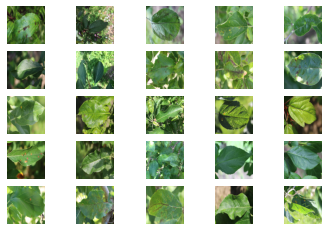

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

## Building a model
We need to define:
* Input Shape
* Output Shape
* Model URL which we will use from Tensorflow Hub

In [0]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

OUTPUT_SHAPE = 4

MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Now let's put all these things together in a keras deep learning model

In [0]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f'Building model with {model_url}')

  # Setup model layers
  model = tf.keras.Sequential([
                hub.KerasLayer(model_url),
                tf.keras.layers.Dense(units=output_shape,
                                      activation='softmax')
  ])

  # Compile the layer
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(input_shape)

  return model

In [0]:
model = create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  4008      
Total params: 5,436,721
Trainable params: 4,008
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks
We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

#### Tensorboard Callback

In [0]:
# Load the tensorboard notebook extension
%load_ext tensorboard

In [0]:
import os

In [0]:
import datetime

# Create a function to create tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing Tensorboard logs
  logdir = os.path.join('drive/My Drive/Plant Pathology Project/logs',
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  
  return tf.keras.callbacks.TensorBoard(logdir)

#### Early stopping callback

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)


## Training a model

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [0]:
def train_model():
  # Create model
  model = create_model()

  # Create Tensorboard seesion everytime we run a model
  tensorboard = create_tensorboard_callback()

  # Fit the model
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [0]:
model = train_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
46/46 [==============================] - 43s 941ms/step - loss: 0.9400 - accuracy: 0.6415 - val_loss: 0.6372 - val_accuracy: 0.7507
Epoch 2/100
46/46 [==============================] - 42s 916ms/step - loss: 0.5451 - accuracy: 0.8146 - val_loss: 0.5316 - val_accuracy: 0.7973
Epoch 3/100
46/46 [==============================] - 42s 909ms/step - loss: 0.4542 - accuracy: 0.8496 - val_loss: 0.4725 - val_accuracy: 0.8384
Epoch 4/100
46/46 [==============================] - 43s 937ms/step - loss: 0.4162 - accuracy: 0.8578 - val_loss: 0.4587 - val_accuracy: 0.8384
Epoch 5/100
46/46 [==============================] - 42s 914ms/step - loss: 0.3839 - accuracy: 0.8716 - val_loss: 0.4275 - val_accuracy: 0.8575
Epoch 6/100
46/46 [==============================] - 41s 882ms/step - loss: 0.3517 - accuracy: 0.8832 - val_loss: 0.4235 - val_accuracy: 0.8630
Epoch 7/100
46/46 [=========================

## Checking the tensorboard logs

In [0]:
%tensorboard --logdir drive/My\ Drive/Plant\ Pathology\ Project/logs

<IPython.core.display.Javascript object>

## Making and evaluating the trained model

In [0]:
predictions = model.predict(val_data, verbose=1)
predictions

12/12 [==============================] - 8s 664ms/step


array([[2.3289071e-03, 7.0315674e-02, 1.7009657e-02, 9.1034567e-01],
       [7.1312088e-01, 1.2198887e-01, 9.2042379e-02, 7.2847873e-02],
       [4.3844202e-01, 2.0945519e-01, 2.5354292e-02, 3.2674846e-01],
       ...,
       [3.4248851e-02, 5.4086321e-03, 1.2101815e-03, 9.5913237e-01],
       [2.3715607e-04, 3.6996838e-02, 4.0239324e-03, 9.5874202e-01],
       [3.0293944e-03, 8.9077847e-03, 9.8642886e-01, 1.6339810e-03]],
      dtype=float32)

In [0]:
import numpy as np


In [0]:
columns = ['healthy', 'multiple_diseases', 'rust',  'scab']

In [0]:
index = 81
print(f"Max Value (probability of predictions: {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max Index: {np.argmax(predictions[index])}")
print(f"Predicted label: {columns[np.argmax(predictions[index])]}")

Max Value (probability of predictions: 0.41261449456214905
Sum: 1.0
Max Index: 2
Predicted label: rust


In [0]:
# Turn prediction probabilities into there respective labels(easier to understand)

def get_pred_label(prediction_probabilities):
  return columns[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[0])
pred_label

'scab'

Since our validation data is in batches, we have to unbatchify it to make predictions

In [0]:
def unbatchify(data):
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(columns[np.argmax(label)])

  return images, labels

# Unbatchify validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.20569855, 0.21746325, 0.1351103 ],
         [0.20877978, 0.22054449, 0.13819154],
         [0.2178309 , 0.2295956 , 0.14724265],
         ...,
         [0.77647066, 0.78823537, 0.72156864],
         [0.77647066, 0.7843138 , 0.7294118 ],
         [0.76697725, 0.7748204 , 0.7199184 ]],
 
        [[0.18069854, 0.19246325, 0.12579657],
         [0.19494487, 0.20670958, 0.1400429 ],
         [0.21176472, 0.22352943, 0.14117648],
         ...,
         [0.7725491 , 0.7843138 , 0.7176471 ],
         [0.77647066, 0.7843138 , 0.7294118 ],
         [0.76890707, 0.7767502 , 0.7218482 ]],
 
        [[0.102486  , 0.11608894, 0.06098127],
         [0.15030637, 0.16390932, 0.10674459],
         [0.19814865, 0.20991336, 0.13126314],
         ...,
         [0.7725491 , 0.7843138 , 0.7176471 ],
         [0.77647066, 0.7843138 , 0.7294118 ],
         [0.76106393, 0.76890707, 0.71400505]],
 
        ...,
 
        [[0.36147586, 0.4319897 , 0.33865547],
         [0.48077297, 0.5149685 , 0.42645

Now let's make a function to make these predictions morte visual

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred_label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of title according to the prediction
  if pred_label == true_label:
    color='green'
  else:
    color='red'

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

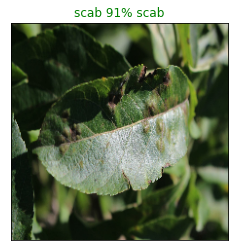

In [0]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=0)

Let's make another function to visualise the extent of predictions

In [0]:
def plot_pred_conf(n=1):
  pred_prob = predictions[n]
  

  # Set the plot
  top_plot = plt.bar(np.arange(len(columns)),
          pred_prob,
          color='orange')
  
  plt.xticks(np.arange(len(columns)),
             labels=columns,
             rotation='vertical')
  
  # Compare the true_label and the predicted label
  true_label = val_labels[n]
  pred_label = get_pred_label(pred_prob)

  # Change the color of true label
  for i in range(len(columns)):
    if columns[i] == true_label:
      top_plot[i].set_color("green")
      break
  

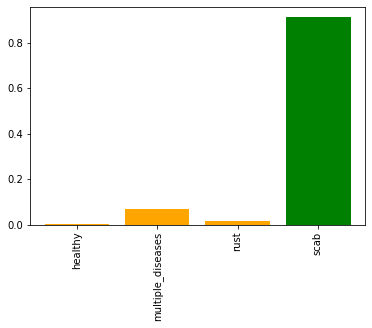

In [0]:
plot_pred_conf(n=0)

Now that we have functions for visualising the predictions, let's check out some images and the predicted label.

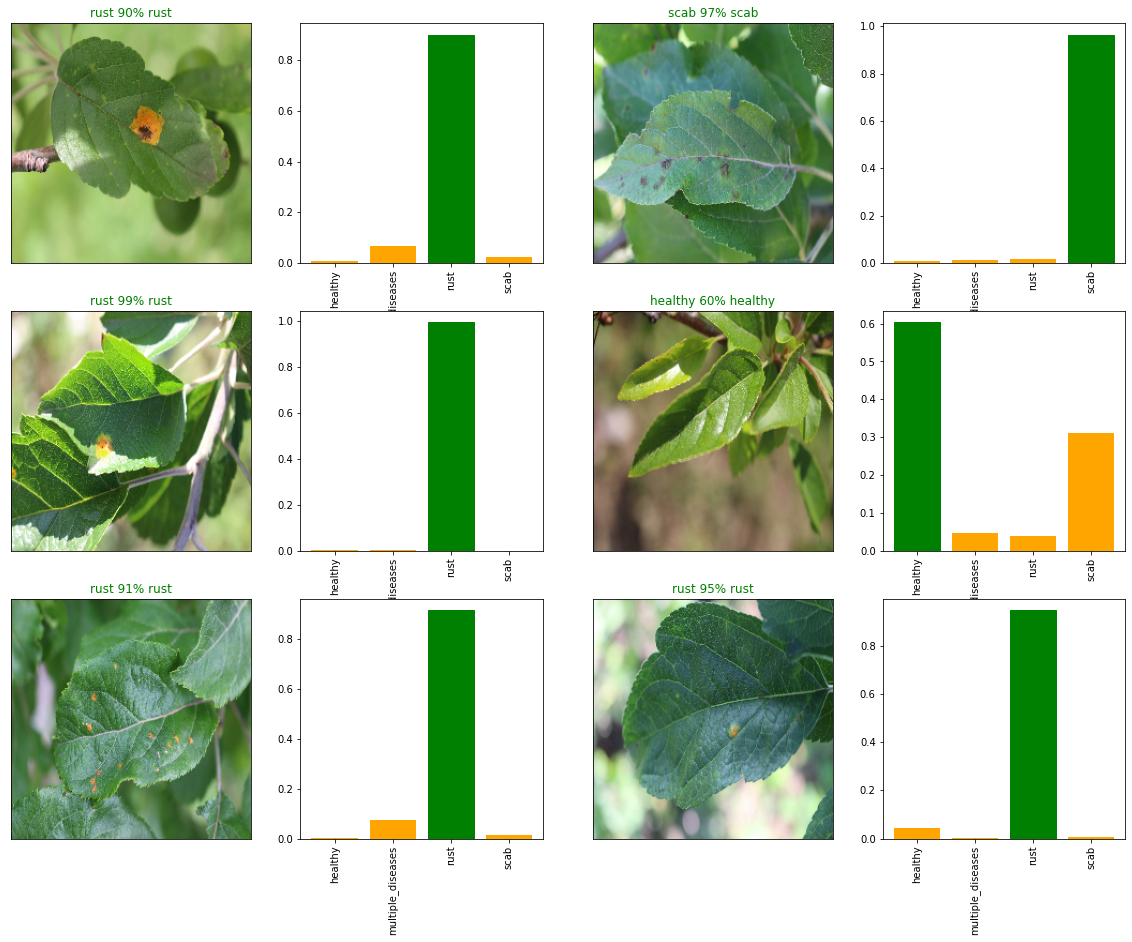

In [0]:
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(n=i+i_multiplier)

plt.show()

## Saving and reloading a trained model

In [0]:
# Create a function to save a model
def save_model(model, suffix=None):
  model_dir = os.path.join('drive/My Drive/Plant Pathology Project/Models',
                           datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  
  model_path = model_dir + '-' + suffix + '.h5'
  print(f'Saving the model to {model_path}...')

  model.save(model_path)
  return model_path

In [0]:
save_model(model, suffix='mobilenet-V2-Adam')

Saving the model to drive/My Drive/Plant Pathology Project/Models/20200404-153304-mobilenet-V2-Adam.h5...


'drive/My Drive/Plant Pathology Project/Models/20200404-153304-mobilenet-V2-Adam.h5'

## Making predictions on test dataset

Since our model has been trained on images in the form of Tensor batches, we will have to caonvert the test data into the same form

In [42]:
test_df = pd.read_csv('drive/My Drive/Plant Pathology Project/test.csv')
test_df.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [43]:
test_filenames = ['drive/My Drive/Plant Pathology Project/images/' + fname for fname in test_df['image_id'] + '.jpg']

test_filenames[:10]

['drive/My Drive/Plant Pathology Project/images/Test_0.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_1.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_2.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_3.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_4.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_5.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_6.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_7.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_8.jpg',
 'drive/My Drive/Plant Pathology Project/images/Test_9.jpg']

In [44]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [0]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on the test data
test_predictions = model.predict(test_data,
                                 verbose=1)

57/57 [==============================] - 1214s 21s/step


In [0]:
test_predictions[:10]

array([[4.79499670e-03, 4.20183063e-01, 5.48846543e-01, 2.61754375e-02],
       [1.52179832e-03, 4.94965538e-02, 9.40819383e-01, 8.16226378e-03],
       [3.85486917e-03, 1.68957410e-03, 5.78391373e-05, 9.94397759e-01],
       [9.80672777e-01, 1.90189414e-04, 1.52286596e-03, 1.76141355e-02],
       [4.21437960e-07, 5.29398785e-05, 9.99942660e-01, 3.97000213e-06],
       [4.50703651e-01, 1.32720798e-01, 3.72371316e-01, 4.42041866e-02],
       [9.94940400e-01, 3.81911697e-04, 2.19109395e-04, 4.45857504e-03],
       [2.18948062e-05, 6.81923330e-03, 4.32103880e-05, 9.93115723e-01],
       [7.94184045e-04, 8.43548238e-01, 3.51028377e-03, 1.52147233e-01],
       [4.68132257e-01, 6.09740689e-02, 3.68328065e-01, 1.02565646e-01]],
      dtype=float32)

## Preparing the dataset for Kaggle submission

In [0]:
preds_df = pd.DataFrame(columns=["image_id"] + list(columns))
preds_df.head()

Empty DataFrame
Columns: [image_id, healthy, multiple_diseases, rust, scab]
Index: []

In [0]:
preds_df['image_id'] = test_df['image_id']
preds_df[list(columns)] = test_predictions

In [0]:
preds_df.head()

image_id      healthy multiple_diseases         rust        scab
0   Test_0     0.004795          0.420183     0.548847   0.0261754
1   Test_1    0.0015218         0.0494966     0.940819  0.00816226
2   Test_2   0.00385487        0.00168957  5.78391e-05    0.994398
3   Test_3     0.980673       0.000190189   0.00152287   0.0176141
4   Test_4  4.21438e-07       5.29399e-05     0.999943    3.97e-06

In [0]:
preds_df.to_csv('drive/My Drive/Plant Pathology Project/predictions.csv', index=False)

# Improving the model

We will try to improve the model and reduce overfitting by incresing the number of training dataset by using `ImageDataGenerator()` function of keras.

## Creating a function to use ImageDataGenerator()

In [0]:
import os, shutil

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Make a function to generate images
def generate_data(label, filename):
  datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        zoom_range=0.2)

  for fname in filename:
    img = load_img(fname)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    # for loop for saving generated images to file
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='drive/My Drive/Plant Pathology Project/exp/' + label, save_prefix=label, save_format='jpg'):
        i += 1
        if i > 4:
            break 

  label_df = pd.DataFrame(columns=['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'])
  label_df['image_id'] = os.listdir('drive/My Drive/Plant Pathology Project/exp/' + label)
  label_df[label] = 1
  label_df.fillna(0)

  return label_df

Using TensorFlow backend.


## Creating a new dataframe from the above written function

In [0]:
# Rust dataframe
rust = train_labels[train_labels['rust'] == 1]
rust_filenames = ['drive/My Drive/Plant Pathology Project/images/' + fname for fname in rust['image_id'] + '.jpg']

rust_df = generate_data(label='rust', filename=rust_filenames)

In [0]:
# Scab Dataframe
scab = train_labels[train_labels['scab'] == 1]
scab_filenames = ['drive/My Drive/Plant Pathology Project/images/' + fname for fname in scab['image_id'] + '.jpg']

scab_df = generate_data(label='scab', filename=scab_filenames)

In [0]:
# Healthy Dataframe
healthy = train_labels[train_labels['healthy'] == 1]
healthy_filenames = ['drive/My Drive/Plant Pathology Project/images/' + fname for fname in healthy['image_id'] + '.jpg']

healthy_df = generate_data(label='healthy', filename=healthy_filenames)

In [0]:
# Multiple diseases dataframe
multiple_diseases = train_labels[train_labels['multiple_diseases'] == 1]
multiple_diseases_filenames = ['drive/My Drive/Plant Pathology Project/images/' + fname for fname in multiple_diseases['image_id'] + '.jpg']

multiple_diseases_df = generate_data(label='multiple_diseases', filename=multiple_diseases_filenames)

In [0]:
rust_df['image_id'] = ['drive/My Drive/Plant Pathology Project/exp/rust/' + fname for fname in rust_df['image_id']]
scab_df['image_id'] = ['drive/My Drive/Plant Pathology Project/exp/scab/' + fname for fname in scab_df['image_id']]
healthy_df['image_id'] = ['drive/My Drive/Plant Pathology Project/exp/healthy/' + fname for fname in healthy_df['image_id']]
multiple_diseases_df['image_id'] = ['drive/My Drive/Plant Pathology Project/exp/multiple_diseases/' + fname for fname in multiple_diseases_df['image_id']]

In [0]:
data_df = pd.DataFrame(columns=['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'])

data_df = data_df.append(healthy_df, ignore_index=True)
data_df = data_df.append(rust_df, ignore_index=True)
data_df = data_df.append(scab_df, ignore_index=True)
data_df = data_df.append(multiple_diseases_df, ignore_index=True)

In [14]:
len(data_df)

7920

In [15]:
data_df.head()

image_id healthy  ... rust scab
0  drive/My Drive/Plant Pathology Project/exp/hea...       1  ...  NaN  NaN
1  drive/My Drive/Plant Pathology Project/exp/hea...       1  ...  NaN  NaN
2  drive/My Drive/Plant Pathology Project/exp/hea...       1  ...  NaN  NaN
3  drive/My Drive/Plant Pathology Project/exp/hea...       1  ...  NaN  NaN
4  drive/My Drive/Plant Pathology Project/exp/hea...       1  ...  NaN  NaN

[5 rows x 5 columns]

In [0]:
data_df.fillna(0, inplace=True)

In [17]:
data_df.head()

image_id  healthy  ...  rust  scab
0  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0
1  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0
2  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0
3  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0
4  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0

[5 rows x 5 columns]

In [0]:
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [19]:
data_df.head()

image_id  healthy  ...  rust  scab
0  drive/My Drive/Plant Pathology Project/exp/rus...        0  ...     1     0
1  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0
2  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0
3  drive/My Drive/Plant Pathology Project/exp/sca...        0  ...     0     1
4  drive/My Drive/Plant Pathology Project/exp/hea...        1  ...     0     0

[5 rows x 5 columns]

## Creating our validation set on the new dataframe

We will use the functions written at the beginning for this purpose.

In [0]:
X = data_df['image_id']
y = data_df.drop('image_id', axis=1)

In [21]:
# Let's split the data into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

len(X_train), len(X_val), len(y_train), len(y_val)

(7128, 792, 7128, 792)

In [34]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [35]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.int64, name=None)))

## Creating the model

In [36]:
model1 = create_model()
model1.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  4008      
Total params: 5,436,721
Trainable params: 4,008
Non-trainable params: 5,432,713
_________________________________________________________________


## Training the model

In [37]:
model1 = train_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
223/223 [==============================] - 210s 944ms/step - loss: 0.6386 - accuracy: 0.7685 - val_loss: 0.4466 - val_accuracy: 0.8460
Epoch 2/100
223/223 [==============================] - 223s 998ms/step - loss: 0.4401 - accuracy: 0.8409 - val_loss: 0.4145 - val_accuracy: 0.8548
Epoch 3/100
223/223 [==============================] - 223s 998ms/step - loss: 0.3850 - accuracy: 0.8650 - val_loss: 0.3986 - val_accuracy: 0.8662
Epoch 4/100
223/223 [==============================] - 225s 1s/step - loss: 0.3541 - accuracy: 0.8733 - val_loss: 0.3734 - val_accuracy: 0.8611
Epoch 5/100
223/223 [==============================] - 226s 1s/step - loss: 0.3336 - accuracy: 0.8823 - val_loss: 0.3600 - val_accuracy: 0.8763
Epoch 6/100
223/223 [==============================] - 227s 1s/step - loss: 0.3248 - accuracy: 0.8836 - val_loss: 0.3633 - val_accuracy: 0.8750
Epoch 7/100
223/223 [==============

In [40]:
save_model(model1, suffix='ImageDataGenerator')

Saving the model to drive/My Drive/Plant Pathology Project/Models/20200407-130738-ImageDataGenerator.h5...


'drive/My Drive/Plant Pathology Project/Models/20200407-130738-ImageDataGenerator.h5'

## Making predictions on the test dataset

In [45]:
test_predictions = model1.predict(test_data,
                                 verbose=1)

57/57 [==============================] - 927s 16s/step


In [0]:
columns = ['healthy', 'multiple_diseases', 'rust', 'scab']

In [47]:
preds_df = pd.DataFrame(columns=["image_id"] + list(columns))
preds_df.head()

Empty DataFrame
Columns: [image_id, healthy, multiple_diseases, rust, scab]
Index: []

In [0]:
preds_df['image_id'] = test_df['image_id']
preds_df[list(columns)] = test_predictions

In [49]:
preds_df.head()

image_id      healthy multiple_diseases         rust         scab
0   Test_0    0.0032952          0.392369     0.592174    0.0121618
1   Test_1   0.00328934         0.0413619      0.93214     0.023209
2   Test_2    0.0023929        0.00219775  5.53457e-06     0.995404
3   Test_3     0.997472       0.000266208   0.00021778   0.00204366
4   Test_4  1.21256e-06       0.000561988     0.999406  3.07637e-05

In [0]:
preds_df.to_csv('drive/My Drive/Plant Pathology Project/imp_preds.csv', index=False)